# House Prices Prediction using TensorFlow Decision Forests

This notebook walks you through how to train a baseline Random Forest model using TensorFlow Decision Forests on the House Prices dataset made available for this competition.

Roughly, the code will look as follows:

```
import tensorflow_decision_forests as tfdf
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())
```

Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks.

## Import the library

In [2]:
import ydf
print("ydf version:", ydf.__version__)
print(dir(ydf))

ydf version: 0.8.0
['Activation', 'BinaryClassificationLoss', 'CARTModel', 'CartLearner', 'Column', 'DecisionTreeLearner', 'DistributedGradientBoostedTreesLearner', 'Feature', 'GenericLearner', 'GenericModel', 'GradientBoostedTreesLearner', 'GradientBoostedTreesModel', 'IsolationForestLearner', 'IsolationForestModel', 'ModelIOOptions', 'ModelMetadata', 'MultiClassificationLoss', 'NodeFormat', 'RandomForestLearner', 'RandomForestModel', 'RandomSearchTuner', 'RegressionLoss', 'Semantic', 'Task', 'VizierTuner', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_check_install', 'api', 'cc', 'create_vertical_dataset', 'dataset', 'deserialize_model', 'from_sklearn', 'from_tensorflow_decision_forests', 'internal', 'learner', 'load_model', 'metric', 'model', 'monitoring', 'start_worker', 'strict', 'tree', 'util', 'utils', 'verbose', 'version']


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

print("pandas version:", pd.__version__)
print("seaborn version:", sns.__version__)
print("matplotlib version:", matplotlib.__version__)

from pathlib import Path

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

pandas version: 2.2.3
seaborn version: 0.13.2
matplotlib version: 3.10.3


## Load the dataset


In [4]:
# Get the path to the current notebook (only works reliably in scripts or with Jupyter hacks)
current_path = Path().resolve()
ROOT_DIR = current_path.parents[1]  # Up 3 levels

# Example: Construct path to training data in ROOT_DIR/data/train.csv
train_file_path = ROOT_DIR / "data" / "train.csv"

print("Root directory:", ROOT_DIR)
print("Train file path:", train_file_path)



Root directory: D:\Ufunta'ar Alavia\houseprice-regression
Train file path: D:\Ufunta'ar Alavia\houseprice-regression\data\train.csv


In [5]:
dataset_df = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (1460, 81)


The data is composed of 81 columns and 1460 entries. We can see all 81 dimensions of our dataset by printing out the first 3 entries using the following code:

In [6]:
dataset_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


* There are 79 feature columns. Using these features your model has to predict the house sale price indicated by the label column named `SalePrice`.

We will drop the `Id` column as it is not necessary for model training.

In [7]:
dataset_df = dataset_df.drop('Id', axis=1)
dataset_df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


We can inspect the types of feature columns using the following code:

In [8]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

## House Price Distribution

Now let us take a look at how the house prices are distributed.

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


<Axes: xlabel='SalePrice', ylabel='Count'>

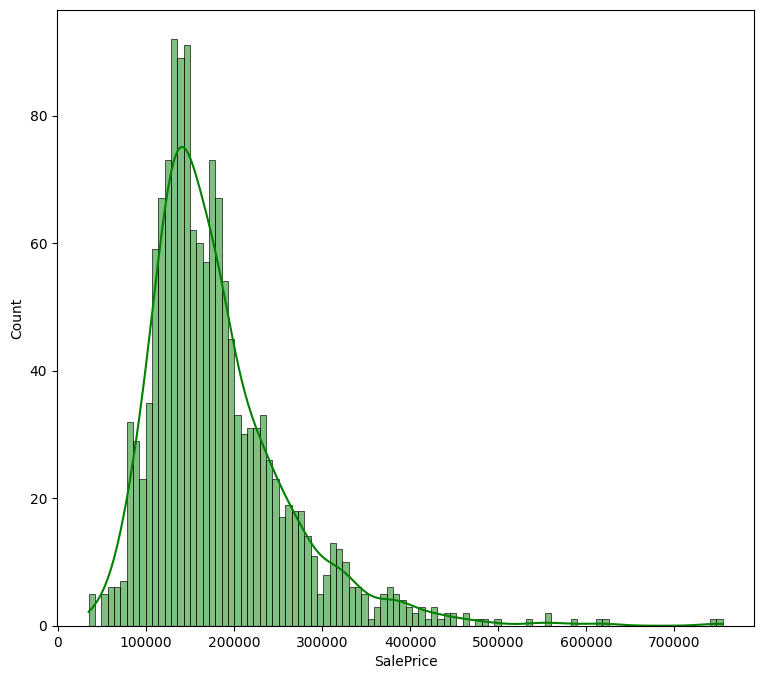

In [10]:
print(dataset_df['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.histplot(dataset_df['SalePrice'], color='g', bins=100, kde=True)

## Numerical data distribution

We will now take a look at how the numerical features are distributed. In order to do this, let us first list all the types of data from our dataset and select only the numerical ones.

In [11]:
list(set(dataset_df.dtypes.tolist()))

[dtype('int64'), dtype('O'), dtype('float64')]

In [12]:
df_num = dataset_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


Now let us plot the distribution for all the numerical features.

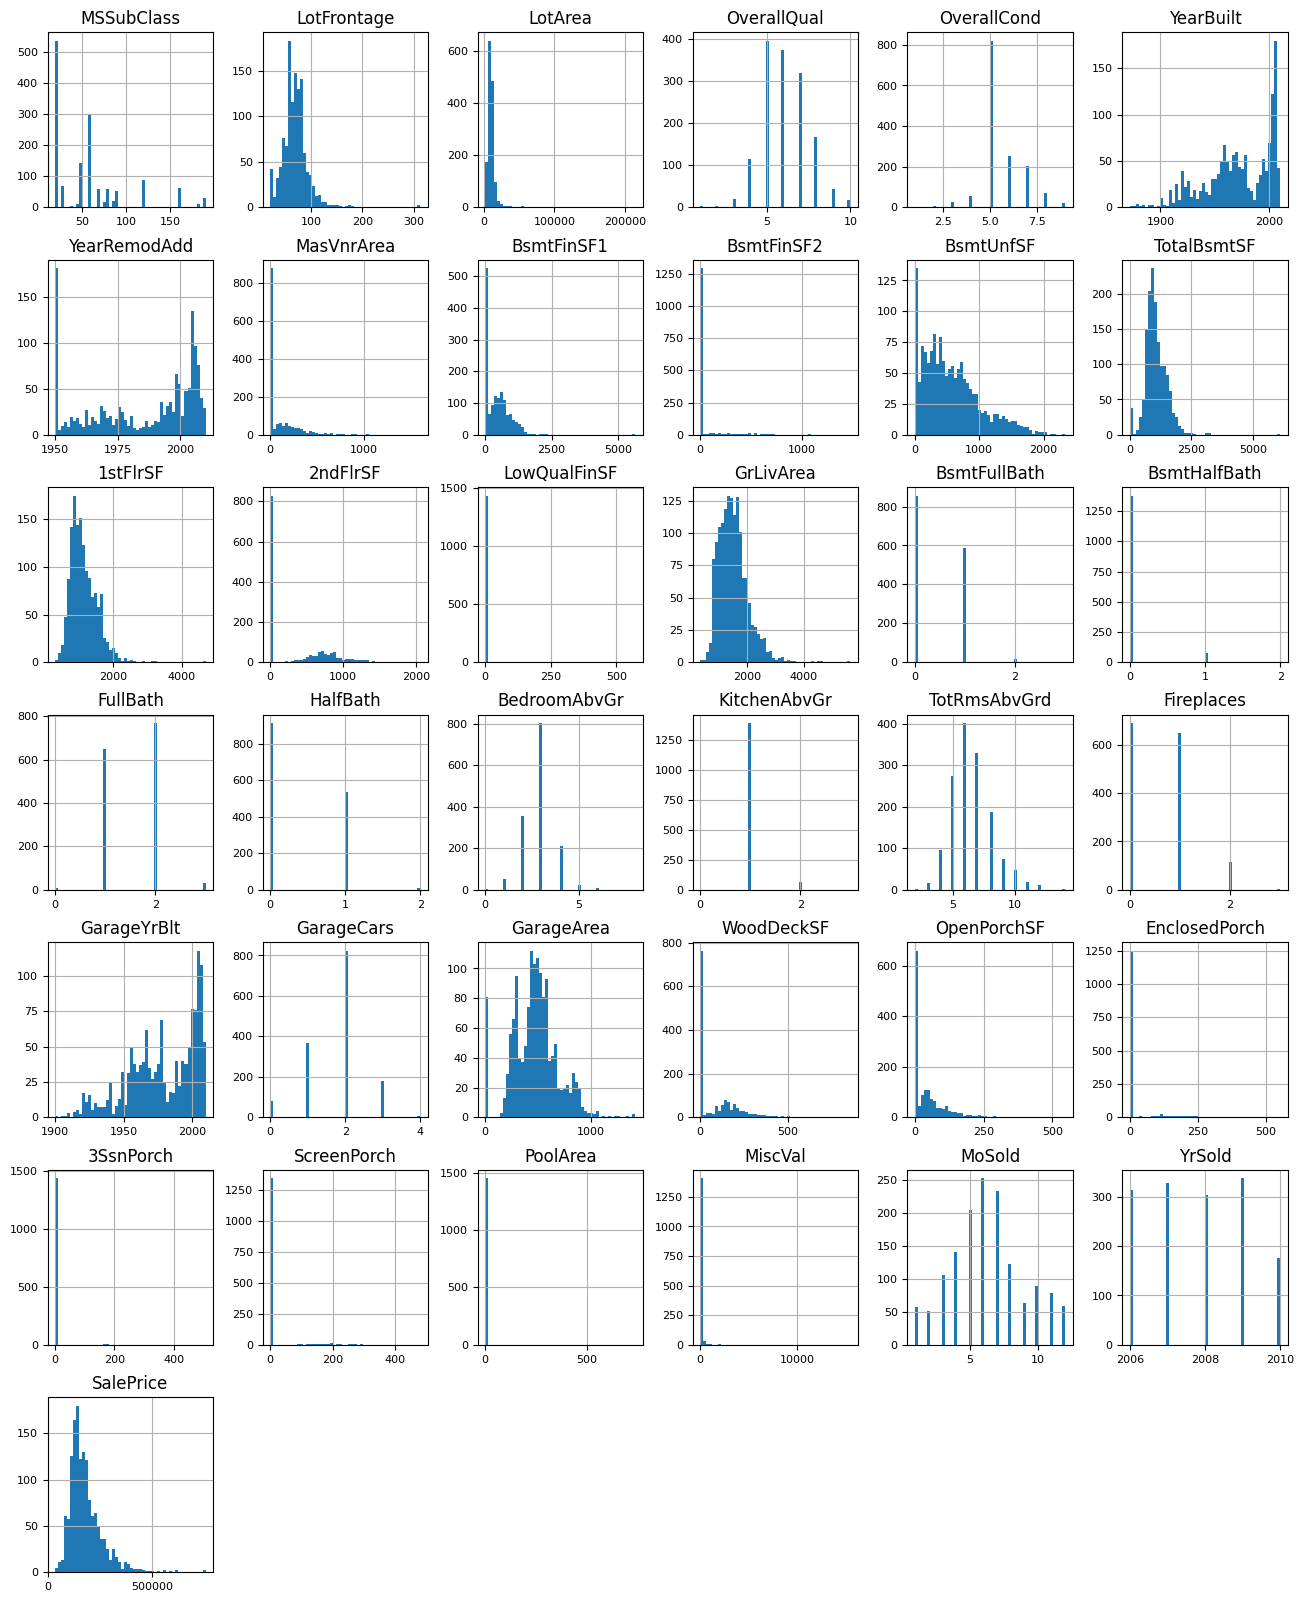

In [13]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

## Prepare the dataset

This dataset contains a mix of numeric, categorical and missing features. TF-DF supports all these feature types natively, and no preprocessing is required. This is one advantage of tree-based models, making them a great entry point to Tensorflow and ML.

Now let us split the dataset into training and testing datasets:

In [6]:
import numpy as np

def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

1043 examples in training, 417 examples in testing.


There's one more step required before we can train the model. We need to convert the datatset from Pandas format (`pd.DataFrame`) into TensorFlow Datasets format (`tf.data.Dataset`).

[TensorFlow Datasets](https://www.tensorflow.org/datasets/overview) is a high performance data loading library which is helpful when training neural networks with accelerators like GPUs and TPUs.

By default the Random Forest Model is configured to train classification tasks. Since this is a regression problem, we will specify the type of the task (`tfdf.keras.Task.REGRESSION`) as a parameter here.

**🔁 YDF equivalent**

YDF (yggdrasil_decision_forests) works directly with Pandas DataFrames — no need to convert to tf.data.Dataset.

You just pass the DataFrame directly to the model’s fit() method, and specify the label column as a parameter.

So, instead of converting the data here, we just store the label name for later and proceed.

In [7]:
label = 'SalePrice'
# train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
#     train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
# valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
#     valid_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)

## Select a Model

There are several tree-based models for you to choose from.

* RandomForestModel
* GradientBoostedTreesModel
* CartModel
* DistributedGradientBoostedTreesModel

To start, we'll work with a Random Forest. This is the most well-known of the Decision Forest training algorithms.

A Random Forest is a collection of decision trees, each trained independently on a random subset of the training dataset (sampled with replacement). The algorithm is unique in that it is robust to overfitting, and easy to use.

We can list the all the available models in TensorFlow Decision Forests using the following code:

**YDF Doesn't really have a port**

✅ Why?
YDF doesn’t use a unified registry like TF-DF does. Instead, you directly instantiate the model class you want from the public API:

python
Copy
Edit
ydf.RandomForestRegressor()
ydf.GradientBoostedTreesRegressor()
ydf.CartRegressor()
(Or the Classifier versions for classification tasks.)

📘 Current available models in YDF:
ydf.RandomForestRegressor()

ydf.RandomForestClassifier()

ydf.GradientBoostedTreesRegressor()

ydf.GradientBoostedTreesClassifier()

ydf.CartRegressor()

ydf.CartClassifier()

These are part of the documented public API, and are not dynamically discoverable via a method like get_all_models().

In [19]:
# tfdf.keras.get_all_models()

print("Available YDF models:")
print(" - ydf.RandomForestRegressor")
print(" - ydf.GradientBoostedTreesRegressor")
print(" - ydf.CartRegressor")
print(" - ...and their Classifier equivalents")

Available YDF models:
 - ydf.RandomForestRegressor
 - ydf.GradientBoostedTreesRegressor
 - ydf.CartRegressor
 - ...and their Classifier equivalents


## How can I configure them?

TensorFlow Decision Forests provides good defaults for you (e.g. the top ranking hyperparameters on our benchmarks, slightly modified to run in reasonable time). If you would like to configure the learning algorithm, you will find many options you can explore to get the highest possible accuracy.

You can select a template and/or set parameters as follows:

```rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1", task=tfdf.keras.Task.REGRESSION)```

Read more [here](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel).

## Create a Random Forest

Today, we will use the defaults to create the Random Forest Model while specifiyng the task type as `tfdf.keras.Task.REGRESSION`.

**✅ YDF Equivalent**

In YDF, the API is non-Keras and simpler. You instantiate a model from ydf.RandomForestRegressor() for regression problems.

You do not call compile(), and you set the label during .fit().

In [20]:
# rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
# rf.compile(metrics=["mse"]) # Optional, you can use this to include a list of eval metrics
learner = ydf.RandomForestLearner(
    label=label,
    task=ydf.Task.REGRESSION,
    num_trees=300,  # Default is 300, same as TFDF
    max_depth=16,   # Optional: control tree depth
    min_examples=5  # Optional: minimum examples per node
)

## Train the model

We will train the model using a one-liner.

Note: you may see a warning about Autograph. You can safely ignore this, it will be fixed in the next release.

**✅ YDF Equivalent**

You train using the Pandas DataFrame directly, passing the label column name:

In [21]:
# rf.fit(x=train_ds)

model = learner.train(train_ds_pd)


Train model on 1043 examples


Model trained in 0:00:00.169298


## Visualize the model (Not in YDF)
One benefit of tree-based models is that you can easily visualize them. The default number of trees used in the Random Forests is 300. We can select a tree to display below.

In [30]:
# YDF doesn't have built-in tree plotting in 0.8.0, but we can:
# Only working option: Get model summary
print(model)

model.describe()

# model.print_tree()

Model: RANDOM_FOREST
Task: REGRESSION
Class: ydf.RandomForestModel
Use `model.describe()` for more details



## Evaluate on the validation dataset

Before training the dataset we have manually seperated 20% of the dataset for validation named as `valid_ds`.

We can also use Out of bag (OOB) score to validate our RandomForestModel.
To train a Random Forest Model, a set of random samples from training set are choosen by the algorithm and the rest of the samples are used to finetune the model.The subset of data that is not chosen is known as Out of bag data (OOB).
OOB score is computed on the OOB data.

Read more about OOB data [here](https://developers.google.com/machine-learning/decision-forests/out-of-bag).

The training logs show the Root Mean Squared Error (RMSE) evaluated on the out-of-bag dataset according to the number of trees in the model. Let us plot this.

Note: Smaller values are better for this hyperparameter.

**✅ YDF Equivalent**

Ignore all of the OOB stuff and just jump to validation dataset

Now, let us run an evaluation using the validation dataset.

In [ ]:
predictions = model.predict(valid_ds_pd)
evaluation = model.evaluate(valid_ds_pd)

evaluation


Evaluation()

## Variable importances

Variable importances generally indicate how much a feature contributes to the model predictions or quality. There are several ways to identify important features using TensorFlow Decision Forests.
Let us list the available `Variable Importances` for Decision Trees:

In [ ]:
# can simply get it from analysis in ydf
analysis = model.analyze(valid_ds_pd)
analysis
# can select variable importances and "NUM AS ROOT in the print"

As an example, let us display the important features for the Variable Importance `NUM_AS_ROOT`.

The larger the importance score for `NUM_AS_ROOT`, the more impact it has on the outcome of the model.

By default, the list is sorted from the most important to the least. From the output you can infer that the feature at the top of the list is used as the root node in most number of trees in the random forest than any other feature.

In [52]:
# print(type(analysis))
variable_importances = analysis.variable_importances()
print(variable_importances.keys())
num_as_root_importances = variable_importances["[In model] NUM_AS_ROOT"]
print(num_as_root_importances)

dict_keys(['[In model] NUM_AS_ROOT', '[In model] SUM_SCORE', '[In model] INV_MEAN_MIN_DEPTH', '[In model] NUM_NODES', 'MEAN_INCREASE_IN_RMSE'])
[(87.0, 'OverallQual'), (67.0, 'ExterQual'), (45.0, 'GarageCars'), (34.0, 'Neighborhood'), (16.0, 'GrLivArea'), (16.0, 'KitchenQual'), (11.0, 'YearBuilt'), (9.0, 'BsmtQual'), (4.0, 'TotalBsmtSF'), (4.0, 'GarageArea'), (2.0, '1stFlrSF'), (2.0, 'GarageYrBlt'), (2.0, 'GarageFinish'), (1.0, 'FireplaceQu')]


Plot the variable importances from the inspector using Matplotlib

<Figure size 1200x400 with 0 Axes>

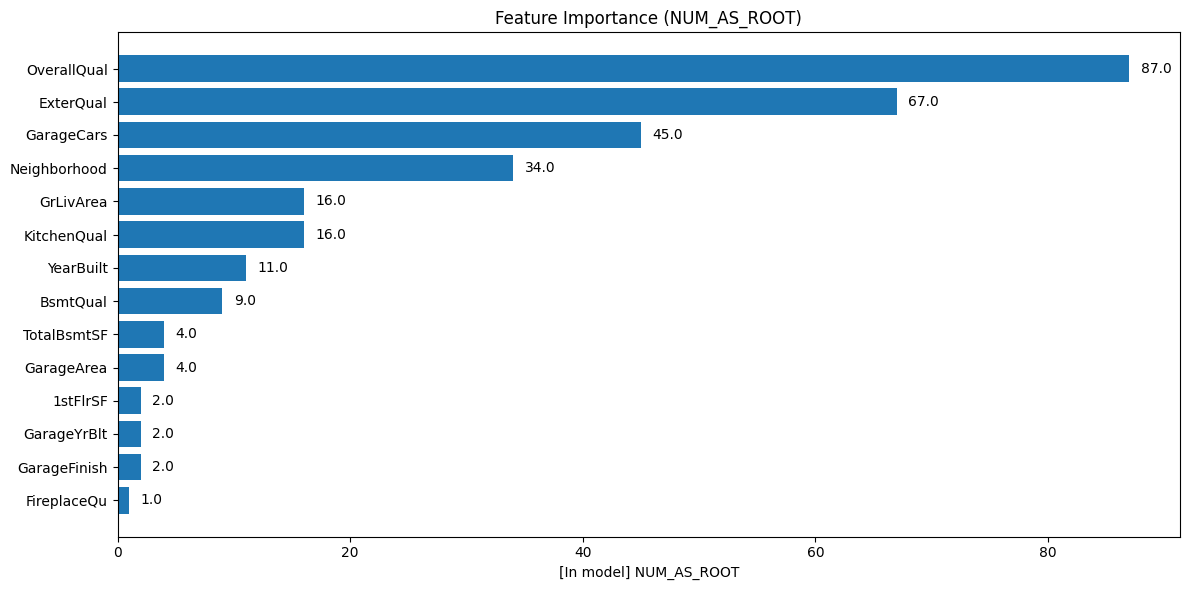

In [53]:
plt.figure(figsize=(12, 4))

# Use the correct key
variable_importance_metric = "[In model] NUM_AS_ROOT"
variable_importances = variable_importances[variable_importance_metric]

# Unpack the tuples: (importance, feature_name)
importance_scores = [vi[0] for vi in variable_importances]
feature_names = [vi[1] for vi in variable_importances]
feature_ranks = range(len(feature_names))

# Plotting
plt.figure(figsize=(12, 6))
bar = plt.barh(feature_ranks, importance_scores)

plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()  # Highest importance on top

# Add labels to each bar
for score, patch in zip(importance_scores, bar.patches):
    plt.text(patch.get_width() + 1, patch.get_y() + patch.get_height() / 2,
             f"{score:.1f}", va="center")

plt.xlabel(variable_importance_metric)
plt.title("Feature Importance (NUM_AS_ROOT)")
plt.tight_layout()
plt.show()

# Submission
Finally predict on the competition test data using the model.

In [23]:
test_file_path = "../input/house-prices-advanced-regression-techniques/test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('Id')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

output.head()


2/2 [==============================] - 1s 24ms/step


,Id,SalePrice
0,1461,123554.718750
1,1462,153939.062500
2,1463,176793.765625
3,1464,183828.296875
4,1465,193644.484375


In [24]:
sample_submission_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
sample_submission_df['SalePrice'] = rf.predict(test_ds)
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()

2/2 [==============================] - 0s 24ms/step


,Id,SalePrice
0,1461,123554.718750
1,1462,153939.062500
2,1463,176793.765625
3,1464,183828.296875
4,1465,193644.484375
